# Bayesian Linear Regression

George Ho 9/27/17

This notebook illustrates Baysian linear regression.

## Sequential Bayesian Linear Regression (PRML Figure 3.7)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set_style("white")
from itertools import chain

In [2]:
# Number of observations
num_obs = 20

# f(x) = (a_0) + (a_1)x + noise
a_0 = 0.3    # Intercept (ground truth)
a_1 = 0.5    # Slope (ground truth)
beta = 25    # Precision (known)
alpha = 2    # Hyperparameter

In [3]:
def plot_likelihood(label, obs, ax=None):
    if ax is None:
        ax = plt.gca()

    x, y = np.mgrid[-1:1:0.01, -1:1:0.01]
    likelihood = np.sqrt(beta/(2*np.pi))*np.exp((-beta/2)*(label - x - y*obs)**2)

    sns.heatmap(likelihood, cmap='jet', cbar=False, xticklabels=False, yticklabels=False, ax=ax)
    ax.set_xlabel('w_0')
    ax.set_ylabel('w_1')

    return ax

In [4]:
def plot_gaussian(mean=[0, 0], cov=[[1, 0], [0, 1]], ax=None):
    '''
    Modified from scipy documentation
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
    '''
    if ax is None:
        ax = plt.gca()

    mean = list(chain(*mean.tolist()))
    cov = cov.tolist()

    x, y = np.mgrid[-1:1:0.01, -1:1:0.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multivariate_normal(mean, cov)
    ax.contourf(y, x, rv.pdf(pos), cmap='jet')
    ax.set_xlabel('w_0')
    ax.set_ylabel('w_1')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.scatter(a_0, a_1, marker='P', color='white')
    
    return ax

In [5]:
def plot_posterior_samples(m, S, x=None, t=None, ax=None):
    if ax is None:
        ax = plt.gca()

    coeffs = np.random.multivariate_normal(m.flatten(), S, 6)

    foo = np.linspace(-1, 1)
    for i in range(6):
        bar = coeffs[i, 0] + coeffs[i, 1]*foo
        ax.plot(foo, bar)
        ax.set_xlabel('w_0')
        ax.set_ylabel('w_1')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)

    if x is not None and t is not None:
        ax.scatter(x, t)

    return ax

In [6]:
def design(x):
    if type(x) == np.float64:
        design = np.ones((1, 2))        
    else:
        design = np.ones((len(x), 2))
    design[:,1] = x
    return design

In [7]:
def update(m, S, phi, t):
    S_updated = np.linalg.inv(np.linalg.inv(S) + beta*np.dot(np.transpose(phi), phi))
    m_updated = np.dot(S_updated, np.dot(np.linalg.inv(S), m) + beta*np.dot(np.transpose(phi), t))

    return m_updated, S_updated

In [8]:
# Generate observations
x = np.random.uniform(-1, 1, num_obs)
t = a_0*x + a_1 + np.random.normal(0, np.sqrt(1/beta), num_obs)

# Prior
m0 = np.array([[0], [0]])
S0 = alpha * np.identity(2)

# Learning from 1st observation/label
m1, S1 = update(m0, S0, design(x[0]), t[0])

# Learning from 2nd observation/label
m2, S2 = update(m1, S1, design(x[1]), t[1])

# Learning from the rest of the data
# Reshape t[1:] into a 20x1 column vector to avoid treacherous numpy broadcasting
m20, S20 = update(m2, S2, design(x[1:]), np.reshape(t[1:], (len(t[1:]), 1)))

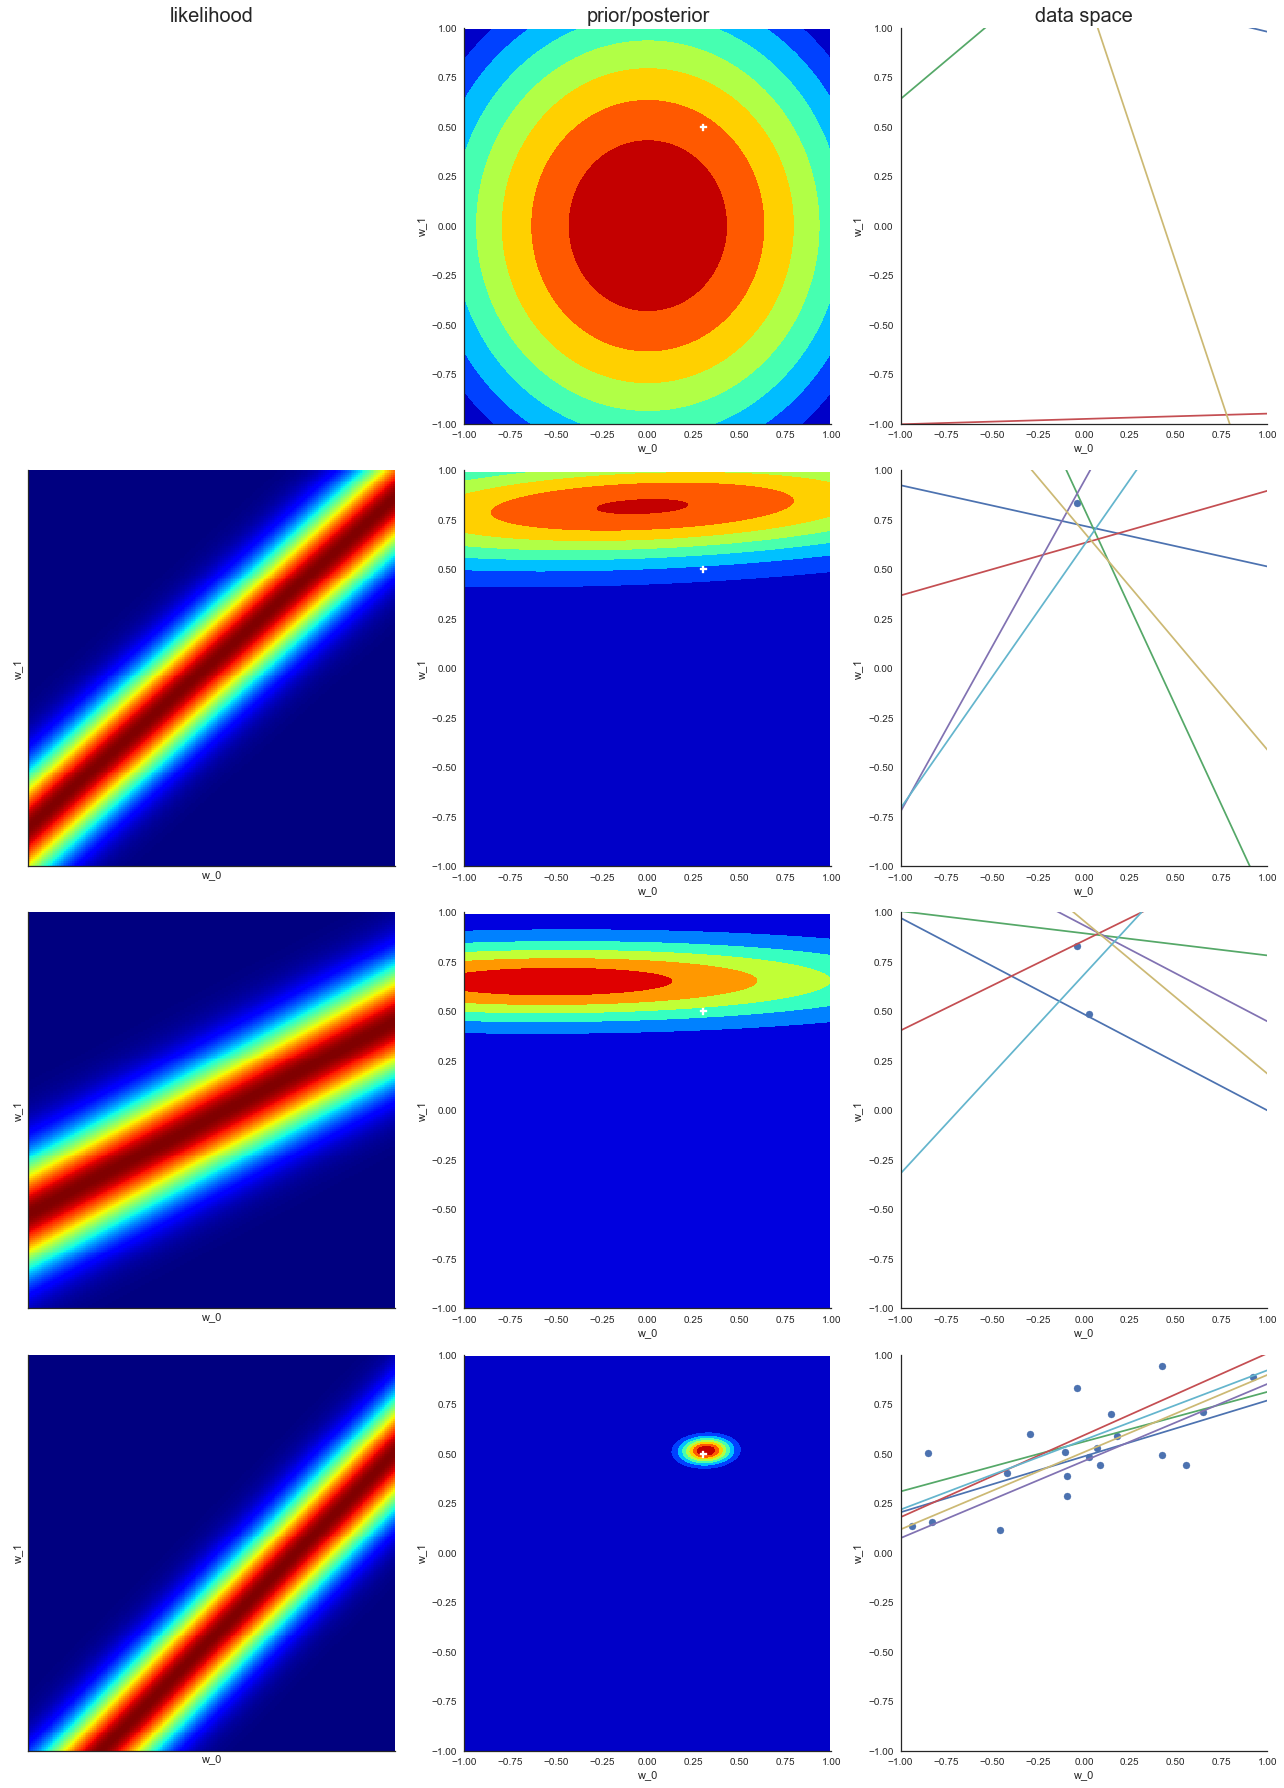

In [9]:
# Plot the things
fig, axarr = plt.subplots(nrows=4, ncols=3, figsize=[18, 25])

axarr[0, 0].set_title('likelihood', fontsize=20)
axarr[0, 0].axis('off')
axarr[0, 1].set_title('prior/posterior', fontsize=20)
axarr[0, 2].set_title('data space', fontsize=20)

plot_gaussian(m0, S0, axarr[0, 1])
plot_posterior_samples(m0, S0, ax=axarr[0, 2])

plot_likelihood(x[0], t[0], axarr[1, 0])
plot_gaussian(m1, S1, axarr[1, 1])
plot_posterior_samples(m1, S1, x[0], t[0], axarr[1, 2])

plot_likelihood(x[1], t[1], axarr[2, 0])
plot_gaussian(m2, S2, axarr[2, 1])
plot_posterior_samples(m2, S2, x[:2], t[:2], axarr[2, 2])

plot_likelihood(x[-1], t[-1], axarr[3, 0])
plot_gaussian(m20, S20, axarr[3, 1])
plot_posterior_samples(m20, S20, x, t, axarr[3, 2])

plt.tight_layout()
sns.despine(fig)
plt.show()

## Predictive Distribution (PRML Figure 3.8)